### Testbed for constructing Binance Market Module
1. Create module to ingest data as flat files
2. Allow for pagination to resolve for API rate limit
3. Daily data upload from Binance API
4. Create module to retrieve files

In [255]:
# Binance Market Module Testbed

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import datetime as dt
import math
import os
import requests  # requests module to interact with endpoints

In [404]:
# construct class to store exchange information and ingest data, for Spot
class BinanceMarketModule:
    
    # provide class variables
    spot_base_url = 'https://api3.binance.com'
    lin_futures_base_url = 'https://fapi.binance.com'
    inv_futures_base_url = 'https://dapi.binance.com'
    
    # store symbolmaster paths
    spot_smpath = 'spot_symbolmaster.feather'
    lin_futures_smpath = 'lin_symbolmaster.feather'
    inv_futures_smpath = 'inv_symbolmaster.feather'
    
    # intervals: 1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 6h, 8h, 12h, 1d, 3d, 1w, 1M
    
    # initialise constructor to token_type input
    def __init__(self, token_type: str):
        self.token_type = token_type
        self._assign_api()  # assign the right api
        self.base_url = self._assign_api()
        self.smpath = self._smpath()
        self.symbolmaster = None
        self.tokenlist = None
        
    # update symbolmaster
    def pullSymbolMaster(self) -> pd.DataFrame:
        # check if symbolmaster already exists in local directory
        self.smpath= self._smpath()
        if os.path.exists(self.smpath):
            df = pd.read_feather(self.smpath)

        # if symbolmaster does not currently exist, construct new symbolmaster
        else:
            exchange_url = '/api/v3/exchangeInfo'
            endpoint = self.base_url + exchange_url
            response = self._get(endpoint)
            symbolmaster_cols = ['symbol', 'status', 'baseAsset', 'quoteAsset']
            df = pd.DataFrame(response['symbols'])[symbolmaster_cols]
            df['timestamp_utc'] = dt.datetime.now(dt.timezone.utc)
            df['date_utc'] = df['timestamp_utc'].apply(lambda x: x.strftime("%Y-%m-%d %H:%M:%S"))
        
        self.symbolmaster = df
        self.tokenlist = df['symbol'].values
        return self.symbolmaster
    
    # store symbolmaster as feather
    def storeSymbolMaster(self):
        # if it currently does not exist
        if self.symbolmaster is None:
            self.pullSymbolMaster()
        # if symbolmaster exists
        else:
            self.symbolmaster.to_feather(self.smpath)
            print(f'Symbol Master stored as {self.smpath}')
    
    # single pull ticker data
    def pullOHLCV(self, symbol: str, interval: str, start: str, end: str)-> pd.DataFrame:
        # manage duration; start and end formatted as string
        unix_start = self.string_to_unixtime(start)
        unix_end = self.string_to_unixtime(end)
        
        kline_url = '/api/v3/klines'
        full_url = self.base_url + kline_url
        params = {'symbol': symbol,
                  'interval': interval,
                  'limit': 1000,
                  'startTime': unix_start,
                  'endTime': unix_end
                 }
        result = self._get(full_url, params=params)
        cols = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'trades']
        df = pd.DataFrame(result).iloc[:, :7]
        df.columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time']
        df['open_ts'] = df['open_time'].apply(lambda x: dt.datetime.fromtimestamp(x/1000))
        df['close_ts'] = df['close_time'].apply(lambda x: dt.datetime.fromtimestamp(x/1000))
        df['symbol'] = symbol
        df = df[['symbol', 'open_ts', 'open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 
                'close_ts']]

        # convert prices to float
        df['open'] = df['open'].astype(float)
        df['high'] = df['high'].astype(float)
        df['low'] = df['low'].astype(float)
        df['close'] = df['close'].astype(float)
        df['volume'] = df['volume'].astype(float)
        return df
    
    # pull klines by date, with pagination
    def pullBulkOHLCV(self, symbol: str, interval: str, start: str, end: str) -> pd.DataFrame:
        # initiate bulk pull
        bulk_list = []
        new_start = start  # comparison variable
        
        while new_start < end:
            df = self.pullOHLCV(symbol, interval, new_start, end)
            bulk_list.append(df)
            first_close = df['close_ts'].iloc[0].strftime('%Y-%m-%d %H:%M:%S')  # convert to string format
            last_close = df['close_ts'].iloc[-1].strftime('%Y-%m-%d %H:%M:%S')
            last_open = df['open_ts'].iloc[-1].strftime('%Y-%m-%d %H:%M:%S')
            
            # update new start to last close
            new_start = last_close
            
            # exit loop if exceeded intended last time
            if new_start > end:
                break
                
        # merge dataframes
        agg_df = pd.concat(bulk_list, axis=0) # merge all dataframes together
        agg_df.reset_index(drop=True, inplace=True) # reset index
        agg_df.drop(agg_df.index[-1], inplace=True) # exclude last row
        return agg_df
    
    # store bulk OHLCV into local directory, for any duration
    def storeBulkOHLCV(self, symbol: str, interval: str, start_date: str, end_date: str) -> str:
        # after constructing dataframe with pagination, store into local directory
        start_timestring = self.datestring_to_timestring(start_date)
        end_timestring = self.datestring_to_timestring(end_date)
        df = self.pullBulkOHLCV(symbol, interval, start_timestring, end_timestring)
        
        # save in appropriate format
        ohlcv_path = symbol + '_' + interval + '_' + start_date + '_' + end_date
        df.to_feather(ohlcv_path)
        first_open = df['open_ts'].iloc[0]
        last_close = df['close_ts'].iloc[-1]
        print(f'{symbol} for {interval} interval stored for duration {first_open} to {last_close}')
        return df
    
    # library management heuristics
    def manageLibrary(self, interval: str):
        # implement simple library management heuristics, to return package size
        if interval == '1m':
            package_size = 'month'
        elif interval == '1h':
            package_size = 'year'
        elif interval == '1d':
            package_size = 'decade'
        else:
            print('Choose appropriate interval - 1m, 1h or 1d')
            package_size = None
            return package_size
        
            
    # assign appropriate api_urls
    def _assign_api(self) -> str:
        if self.token_type == 'spot':
            self.base_url = self.spot_base_url
        elif self.token_type == 'lin_future':
            self.base_url = self.lin_futures_base_url
        elif self.token_type == 'inv_future':
            self.base_url = self.inv_futures_base_url
        else:
            self.base_url = None
            print('Unknown Token Type')
        return self.base_url
            
    # get request for usage within the class
    def _get(self, full_endpoint: str, params: dict = None):
        r = requests.get(full_endpoint, params=params)
        results = r.json()
        return results
    
    def _smpath(self) -> str:
        if self.token_type == 'spot':
            self.smpath = self.spot_smpath
        elif self.token_type == 'lin_future':
            self.smpath = self.lin_futures_smpath
        elif self.token_type == 'inv_future':
            self.smpath = self.inv_futures_smpath
        else:
            self.smpath = None
            print('Unknown Token Type')
        return self.smpath
    
    # create methods for handling time
    
    @staticmethod
    def string_to_unixtime(timestring: str):  # convert this into UTC unixtime
        unixtime = time.mktime(dt.datetime.strptime(timestring, '%Y-%m-%d %H:%M:%S').timetuple()) * 1000
        return int(unixtime)
    
    @staticmethod
    def datestring_to_timestring(datestring: str):  # convert this into UTC unixtime
        ts = dt.datetime.strptime(datestring, '%Y-%m-%d')
        timestring = ts.strftime('%Y-%m-%d %H:%M:%S')
        return timestring

IndentationError: expected an indented block (4139853816.py, line 146)

In [401]:
b = BinanceMarketModule('spot')

In [402]:
start = '2021-01-01'
end = '2022-12-01'
df = b.storeBulkOHLCV('ETHUSDT', '1h', start, end)

ETHUSDT for 1h interval stored for duration 2021-01-01 00:00:00 to 2022-11-30 23:59:59.999000


In [403]:
df

,symbol,open_ts,open_time,open,high,low,close,volume,close_time,close_ts
0,ETHUSDT,2021-01-01 00:00:00,1609430400000,736.00,736.97,724.48,727.30,45192.35523,1609433999999,2021-01-01 00:59:59.999
1,ETHUSDT,2021-01-01 01:00:00,1609434000000,727.26,743.00,726.59,737.20,41547.83481,1609437599999,2021-01-01 01:59:59.999
2,ETHUSDT,2021-01-01 02:00:00,1609437600000,737.20,740.96,735.28,739.87,18794.08202,1609441199999,2021-01-01 02:59:59.999
3,ETHUSDT,2021-01-01 03:00:00,1609441200000,739.88,742.00,737.36,738.83,14810.28022,1609444799999,2021-01-01 03:59:59.999
4,ETHUSDT,2021-01-01 04:00:00,1609444800000,738.76,744.50,737.61,743.96,14700.26345,1609448399999,2021-01-01 04:59:59.999
...,...,...,...,...,...,...,...,...,...,...
16758,ETHUSDT,2022-11-30 19:00:00,1669806000000,1264.69,1268.14,1264.46,1266.72,8852.24420,1669809599999,2022-11-30 19:59:59.999
16759,ETHUSDT,2022-11-30 20:00:00,1669809600000,1266.73,1268.85,1255.10,1258.80,21709.27630,1669813199999,2022-11-30 20:59:59.999
16760,ETHUSDT,2022-11-30 21:00:00,1669813200000,1258.81,1272.50,1257.70,1262.53,42976.26570,1669816799999,2022-11-30 21:59:59.999
16761,ETHUSDT,2022-11-30 22:00:00,1669816800000,1262.54,1268.14,1261.76,1266.83,22970.04800,1669820399999,2022-11-30 22:59:59.999


In [395]:
pd.read_feather('ETHUSDT_1h_2021-01-01_2022-12-01')

,open_ts,open_time,open,high,low,close,volume,close_time,close_ts
0,2021-01-01 00:00:00,1609430400000,736.00,736.97,724.48,727.30,45192.35523,1609433999999,2021-01-01 00:59:59.999
1,2021-01-01 01:00:00,1609434000000,727.26,743.00,726.59,737.20,41547.83481,1609437599999,2021-01-01 01:59:59.999
2,2021-01-01 02:00:00,1609437600000,737.20,740.96,735.28,739.87,18794.08202,1609441199999,2021-01-01 02:59:59.999
3,2021-01-01 03:00:00,1609441200000,739.88,742.00,737.36,738.83,14810.28022,1609444799999,2021-01-01 03:59:59.999
4,2021-01-01 04:00:00,1609444800000,738.76,744.50,737.61,743.96,14700.26345,1609448399999,2021-01-01 04:59:59.999
...,...,...,...,...,...,...,...,...,...
16758,2022-11-30 19:00:00,1669806000000,1264.69,1268.14,1264.46,1266.72,8852.24420,1669809599999,2022-11-30 19:59:59.999
16759,2022-11-30 20:00:00,1669809600000,1266.73,1268.85,1255.10,1258.80,21709.27630,1669813199999,2022-11-30 20:59:59.999
16760,2022-11-30 21:00:00,1669813200000,1258.81,1272.50,1257.70,1262.53,42976.26570,1669816799999,2022-11-30 21:59:59.999
16761,2022-11-30 22:00:00,1669816800000,1262.54,1268.14,1261.76,1266.83,22970.04800,1669820399999,2022-11-30 22:59:59.999


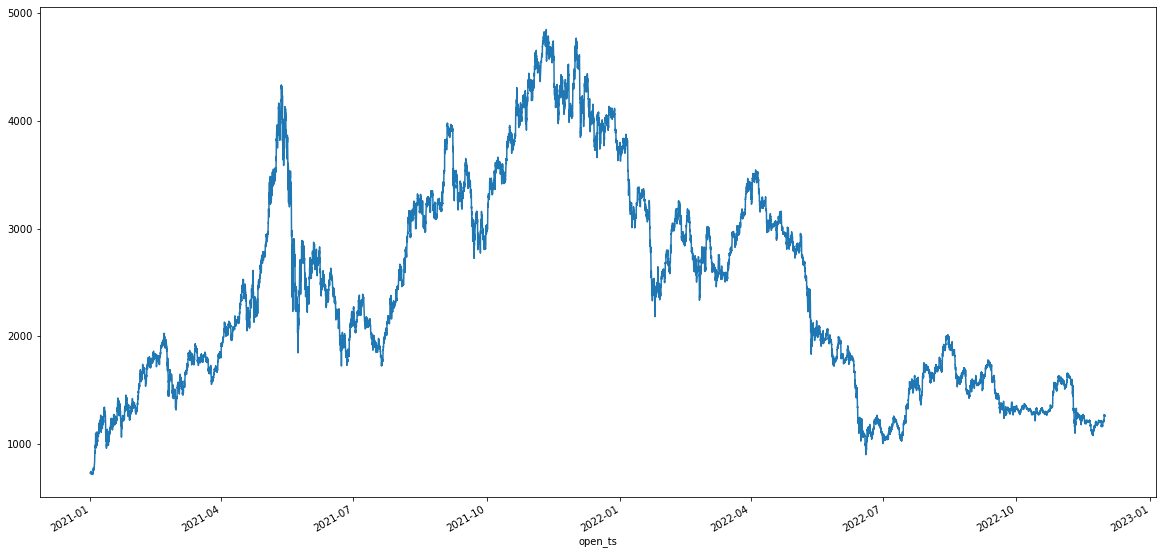

In [399]:
df.set_index('open_ts')['open'].plot(figsize=(20, 10))
plt.show()

In [ ]:
b.storeBulkOHLCV('BTCUSDT', '1m', start, end))

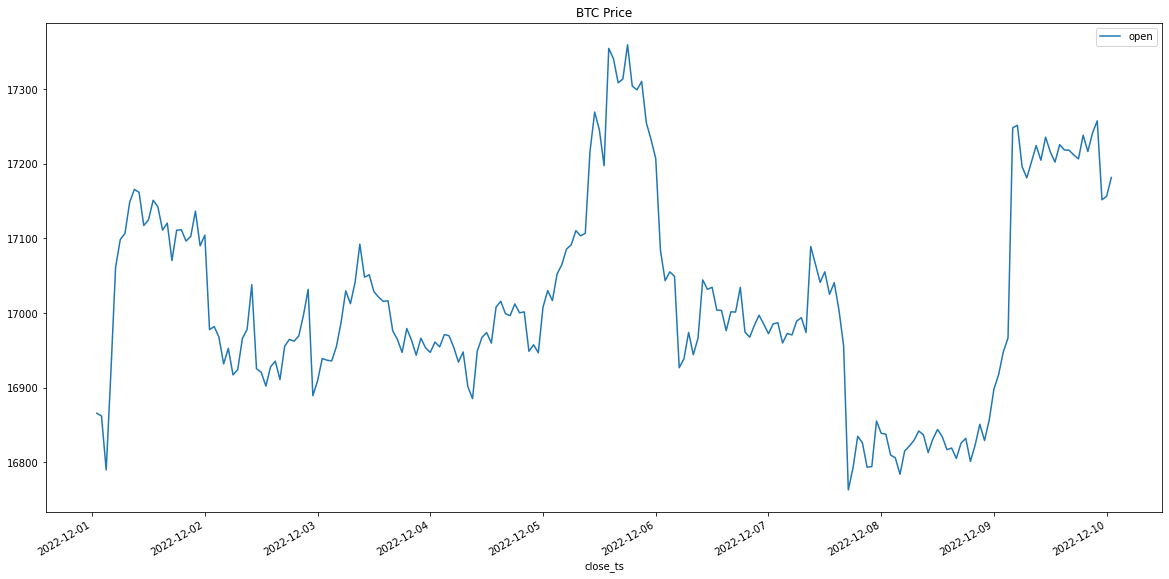

In [273]:
df.set_index('close_ts', inplace=True)
df[['open']].plot(figsize=(20,10), title='BTC Price')
plt.show()

In [296]:
df['close_ts'].iloc[0]

Timestamp('2022-01-01 00:59:59.999000')

In [205]:
df['close_ts'] = df['close_time'].apply(lambda x: dt.datetime.fromtimestamp(x/1000))

In [206]:
df

,open_time,open,high,low,close,volume,close_time,ts
0,1670410800000,16826.09000000,16832.85000000,16780.33000000,16793.29000000,8411.21752000,1670414399999,2022-12-07 19:59:59.999
1,1670414400000,16793.29000000,16810.81000000,16765.12000000,16794.22000000,8176.75442000,1670417999999,2022-12-07 20:59:59.999
2,1670418000000,16794.21000000,16872.00000000,16793.00000000,16855.24000000,12520.82420000,1670421599999,2022-12-07 21:59:59.999
3,1670421600000,16855.24000000,16897.38000000,16821.15000000,16837.91000000,11855.93357000,1670425199999,2022-12-07 22:59:59.999
4,1670425200000,16838.86000000,16858.88000000,16810.01000000,16837.48000000,13029.04588000,1670428799999,2022-12-07 23:59:59.999
...,...,...,...,...,...,...,...,...
495,1672192800000,16695.55000000,16713.41000000,16677.42000000,16683.81000000,5590.53803000,1672196399999,2022-12-28 10:59:59.999
496,1672196400000,16683.81000000,16694.68000000,16559.79000000,16650.65000000,14186.30434000,1672199999999,2022-12-28 11:59:59.999
497,1672200000000,16650.65000000,16678.85000000,16641.25000000,16660.44000000,5941.38788000,1672203599999,2022-12-28 12:59:59.999
498,1672203600000,16660.15000000,16668.00000000,16585.71000000,16602.98000000,10723.34379000,1672207199999,2022-12-28 13:59:59.999


In [20]:
endpoint

'https://api3.binance.com/api/v3/exchangeInfo'

In [41]:
# procure symbol master
symbols = [x['symbol'] for x in response.json()['symbols'] if x['symbol'].__contains__('USDT')]

In [44]:
response.status_code

200

In [47]:
response.json()

{'timezone': 'UTC',
 'serverTime': 1672196066190,
 'rateLimits': [{'rateLimitType': 'REQUEST_WEIGHT',
   'interval': 'MINUTE',
   'intervalNum': 1,
   'limit': 1200},
  {'rateLimitType': 'ORDERS',
   'interval': 'SECOND',
   'intervalNum': 10,
   'limit': 50},
  {'rateLimitType': 'ORDERS',
   'interval': 'DAY',
   'intervalNum': 1,
   'limit': 160000},
  {'rateLimitType': 'RAW_REQUESTS',
   'interval': 'MINUTE',
   'intervalNum': 5,
   'limit': 6100}],
 'exchangeFilters': [],
 'symbols': [{'symbol': 'ETHBTC',
   'status': 'TRADING',
   'baseAsset': 'ETH',
   'baseAssetPrecision': 8,
   'quoteAsset': 'BTC',
   'quotePrecision': 8,
   'quoteAssetPrecision': 8,
   'baseCommissionPrecision': 8,
   'quoteCommissionPrecision': 8,
   'orderTypes': ['LIMIT',
    'LIMIT_MAKER',
    'MARKET',
    'STOP_LOSS_LIMIT',
    'TAKE_PROFIT_LIMIT'],
   'icebergAllowed': True,
   'ocoAllowed': True,
   'quoteOrderQtyMarketAllowed': True,
   'allowTrailingStop': True,
   'cancelReplaceAllowed': True,
   'i

limit_output extension: Maximum message size of 10000 exceeded with 1770841 characters

In [45]:

# check the status code
if response.status_code == 200:
    data = response.json()
    print(data)
else:
    print('Error: status code {}'.format(response.status_code))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

